In [15]:
import os
import random
import torch
import wandb
import numpy as np
from torch import nn
from PIL import Image
from glob import glob
import collections.abc
from pytorch_msssim import ssim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output       
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR

collections.Iterable = collections.abc.Iterable

In [ ]:
DATA_PATH = 'data'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32
wandb.init(project='imej-denoiser', name='DAE-7')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: novebritito. Use `wandb login --relogin` to force relogin


# LOAD IMAGE

In [3]:
# No class for this dataset
class NonClassDataLoader(Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.image_paths = glob(os.path.join(root_dir, '*.jpg')) + \
                   glob(os.path.join(root_dir, '*.jpeg')) + \
                   glob(os.path.join(root_dir, '*.png'))
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transforms:
            image = self.transforms(image)
        return image

In [4]:
# Define the named functions
def add_gaussian_noise(x):
    return x + 0.1 * torch.randn_like(x)

def add_poisson_noise(x):
    return torch.poisson(x * 255) / 255.0

def normalize_tensor(x):
    return torch.clamp(x, 0., 1.)

# Update the transform with named functions
transform = transforms.Compose([
    transforms.Resize((256, 256)), # resize image
    transforms.ToTensor(), # convert image to tensor
    transforms.Lambda(add_poisson_noise), # add poisson noise
    transforms.Lambda(add_gaussian_noise), # add gaussian noise
    transforms.Lambda(normalize_tensor), # normalize tensors to [0, 1]
])

# Load data from folder
noised_data_loader = NonClassDataLoader(root_dir=DATA_PATH, transforms=transform)
clean_data_loader = NonClassDataLoader(root_dir=DATA_PATH, transforms=transforms.Compose([transforms.Resize((256, 256)), transforms.ToTensor()]))

train_data = DataLoader(
    dataset=noised_data_loader,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
)

clean_data = DataLoader(
    dataset=clean_data_loader,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True,
)

# Modelling

## DAE (Denoising AutoEncoder)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
    
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        return out + residual  # Skip connection

# Tiny Transformer Block (Linformer-style)
class TinyTransformerBlock(nn.Module):
    def __init__(self, dim, num_heads=4, reduction=4):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * reduction),
            nn.ReLU(),
            nn.Linear(dim * reduction, dim)
        )

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).flatten(1, 2)  # [B, C, H, W] -> [B, HW, C]
        attn_out, _ = self.attn(self.norm1(x), self.norm1(x), self.norm1(x))
        x = x + attn_out  # Residual
        x = x + self.mlp(self.norm2(x))  # Residual MLP
        x = x.view(x.shape[0], int(x.shape[1] ** 0.5), int(x.shape[1] ** 0.5), x.shape[-1]).permute(0, 3, 1, 2)
        return x  # [B, C, H, W]

class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_channels=3):
        super().__init__()
        # Encoder (CNN)
        self.encoder1 = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=2, padding=1),  # 256x256 -> 128x128
            nn.ReLU(),
            ResidualBlock(32)
        )
        self.encoder2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),              # 128x128 -> 64x64
            nn.ReLU(),
            ResidualBlock(64)
        )
        self.encoder3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),             # 64x64 -> 32x32
            nn.ReLU(),
            ResidualBlock(128)
        )

        # Transformer Bottleneck
        self.transformer = TinyTransformerBlock(dim=128)

        # Decoder (CNN)
        self.decoder3 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),   # 32x32 -> 64x64
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder2 = nn.Sequential(
            nn.ConvTranspose2d(128, 32, kernel_size=3, stride=2, padding=1, output_padding=1),    # 64x64 -> 128x128
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.decoder1 = nn.Sequential(
            nn.ConvTranspose2d(64, input_channels, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128x128 -> 256x256
            nn.Sigmoid()
        )

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(enc1)
        enc3 = self.encoder3(enc2)

        # Transformer Bottleneck
        bottleneck = self.transformer(enc3)

        # Decoder with skip connections
        dec3 = self.decoder3(bottleneck)
        dec2 = self.decoder2(torch.cat([dec3, enc2], dim=1))
        dec1 = self.decoder1(torch.cat([dec2, enc1], dim=1))
        
        return dec1


# Train

In [6]:
def denormalize(tensor):
    """Function to denormalize tensor values back to [0, 1]"""
    return tensor.clamp(0., 1.)

def plot_images(noisy, denoised, clean, epoch, loss):
    """Plot images for each epoch"""
    noisy = denormalize(noisy).cpu().numpy().transpose(0, 2, 3, 1)
    denoised = denormalize(denoised).cpu().numpy().transpose(0, 2, 3, 1)
    clean = denormalize(clean).cpu().numpy().transpose(0, 2, 3, 1)
    difference = np.abs(clean - denoised)

    # Clear the figure to avoid overlapping
    plt.clf()
    
    # randomize the images to show
    random_index = random.randint(0, noisy.shape[0] - 1)
    noisy = noisy[random_index]
    denoised = denoised[random_index]
    clean = clean[random_index]
    difference = difference[random_index]
    
    # Normalize the images to [0, 1] for display
    noisy = (noisy - noisy.min()) / (noisy.max() - noisy.min() + 1e-8)
    denoised = (denoised - denoised.min()) / (denoised.max() - denoised.min() + 1e-8)
    clean = (clean - clean.min()) / (clean.max() - clean.min() + 1e-8)
    difference = (difference - difference.min()) / (difference.max() - difference.min() + 1e-8)
    
    # Create a plot to show noisy, denoised, original, and difference images
    fig, axes = plt.subplots(1, 4, figsize=(16, 5))
    
    # title for the plot
    plt.suptitle(f"Epoch: {epoch}, Loss: {loss.item():.4f}")
    
    # Noisy image   
    axes[0].imshow(noisy)
    axes[0].set_title("Noisy Image")
    axes[0].axis('off')
    
    # Denoised image (model output)
    axes[1].imshow(denoised)
    axes[1].set_title("Denoised Image")
    axes[1].axis('off')
        
    # Difference image
    axes[2].imshow(difference)
    axes[2].set_title("Difference Image")
    axes[2].axis('off')
    
    # Original image
    axes[3].imshow(clean)
    axes[3].set_title("Original Image")
    axes[3].axis('off')

    plt.tight_layout()
    plt.show()
    clear_output(wait=True)


In [7]:
from torchvision.models import vgg16

# Load pre-trained VGG16 model
vgg = vgg16(pretrained=True).features[:8].to(DEVICE).eval()

# Freeze VGG parameters
for param in vgg.parameters():
    param.requires_grad = False

def perceptual_loss(output, target):
    """Calculate perceptual loss using VGG16"""
    output_features = vgg(output)
    target_features = vgg(target)
    return F.mse_loss(output_features, target_features)

def loss_func(output, target):
    huber_loss = F.smooth_l1_loss(output, target, reduction='mean')
    l1_loss = F.l1_loss(output, target, reduction='mean')
    ssim_loss = 1 - ssim(output, target, data_range=1)
    
    # Perceptual Loss dengan layer yang lebih ringan
    with torch.no_grad():  
        output_features = vgg(output)  # Bisa coba layer lebih dangkal
        target_features = vgg(target)
    perc_loss = F.mse_loss(output_features, target_features)
    
    # Kurangi bobot perceptual loss jika perlu
    total_loss = 0.7 * huber_loss + 0.2 * l1_loss + 0.05 * ssim_loss + 0.05 * perc_loss
    return total_loss


In [16]:
epochs = 1000  
dae_model = DenoisingAutoencoder(input_channels=3).to(DEVICE)

optimizer = torch.optim.AdamW(dae_model.parameters(), lr=1e-3, weight_decay=1e-5)

# Warm-up learning rate in first 20 epochs
def lr_lambda(epoch):
    if epoch < 20:
        return epoch / 20  
    return 1  

warmup_scheduler = LambdaLR(optimizer, lr_lambda)

cosine_scheduler = CosineAnnealingLR(optimizer, T_max=500, eta_min=1e-7)

scheduler = torch.optim.lr_scheduler.SequentialLR(optimizer, [warmup_scheduler, cosine_scheduler], milestones=[12])

In [ ]:
print('START TRAINING')
best_loss = float('inf')
epochs_no_improve = 0
n_epochs_stop = 10

for epoch in range(epochs):
    dae_model.train()
    epoch_loss = 0
    for noisy, clean in zip(train_data, clean_data):
        noisy = noisy.to(DEVICE)
        clean = clean.to(DEVICE)
        optimizer.zero_grad()
        
        denoised_img = dae_model(noisy)
        loss = loss_func(denoised_img, clean)
        
        loss.backward()
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=dae_model.parameters(), max_norm=1)
        
        optimizer.step()
        epoch_loss+= loss.item()
        
    epoch_loss /= len(train_data)
        
    scheduler.step()
    
    dae_model.eval()
    with torch.no_grad():
        # randomly select a noisy image and clean image same index
        random_idx = random.randint(0, len(noised_data_loader) - 1)
        noisy_img = noised_data_loader[random_idx].to(DEVICE).unsqueeze(0)
        clean_img = clean_data_loader[random_idx].to(DEVICE).unsqueeze(0)
        
        # denoise the noisy image
        denoised_img = dae_model(noisy_img)
        
        # Calculate psnr and ssim
        psnr = 10 * torch.log10(1 / F.mse_loss(denoised_img, clean_img))
        ssim_val = ssim(denoised_img, clean_img, data_range=1, size_average=True)
        
        # plot the noisy and denoised image
        plot_images(noisy_img, denoised_img, clean_img, epoch, loss)        
        wandb.log({
            'loss': loss.item(),
            'epoch': epoch,
            'psnr': psnr.item(),
            'ssim': ssim_val.item(),
            'denoised_img': wandb.Image(denoised_img[0].cpu().numpy().transpose(1, 2, 0)),
        })
        
    # Early stopping
    if loss < best_loss:
        best_loss = loss
        epochs_no_improve = 0
        # Save the model NOWW!!!
        torch.save(dae_model.state_dict(), 'best_dae_model.pth')
    else:
        epochs_no_improve += 1
    
    if epochs_no_improve == n_epochs_stop:
        print(f'Early stopping at epoch {epoch}')
        break

wandb.finish()

Early stopping at epoch 413


<Figure size 640x480 with 0 Axes>

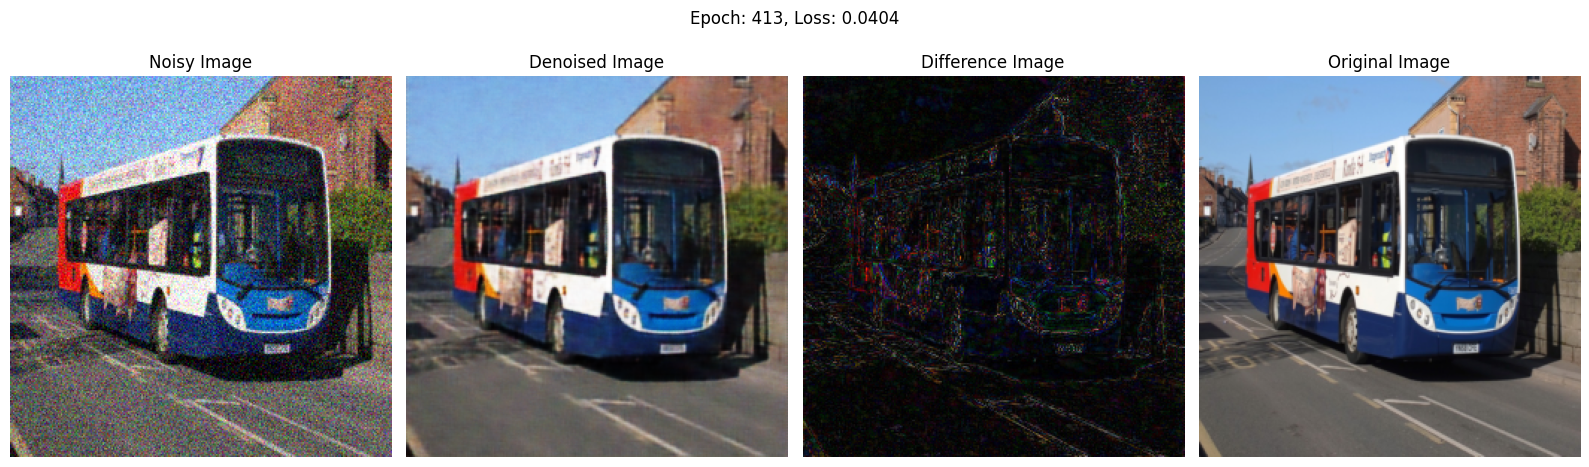

In [20]:
# plot the image using function on last epoch
plot_images(noisy_img, denoised_img, clean_img, epoch, loss)

In [11]:
# Save the model
torch.save(dae_model.state_dict(), 'dae_model.pth')
# save the whole model
torch.save(dae_model, 'dae_model.pt')